Grab an image

In [38]:
from pathlib import Path
image_path = Path("samples/snap_2387.png")

Load Image

In [39]:
import imageio
imag = imageio.imread(image_path)

In [40]:
######################
#   Analog video degradation simulator
#   Version 1.1
#   polprog 2019
#   http://polprog.net/
#   3 clause BSD licensed
######################


import imageio
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gspc
import numpy as np
import os
import sys

# Rec.709 Luma calculation coefficients
COEF_R = 0.2126
COEF_G = 0.7152
COEF_B = 0.0722


# This function is used to run convolution on a single row
def row_convolve(data, period):
    return np.convolve(data, np.ones((period,))/period, mode='valid')

#This function shifts the data in the array
def shift(data, dx, dy):
    n,m=data.shape
    bigdata=np.zeros((3*n,3*m),data.dtype)
    bigdata[n:2*n,m:2*m]=data
    x=n-dx
    y=m-dy
    return bigdata[x:x+n,y:y+m]

#This function expands source array to target shape
def expand(source, targetshape):
    print("..expanding from " + str(source.shape) + " to " + str(targetshape.shape))
    return np.pad(source, ((targetshape.shape[0] - source.shape[0], 0), (targetshape.shape[1] - source.shape[1], 0) ), 'constant', constant_values=(0, 0))

In [41]:
# Create a B/W version of the image
luma = imag[:, :, 0] * COEF_R + imag[:, :, 1] * COEF_G + imag[:, :, 2] * COEF_B

print("Image shape is " + str(imag.shape))

shiftpx = int(imag.shape[0] * 0.01)
print("Will be shifting by a base unit of " + str(shiftpx) + " pixels.")

Image shape is (224, 256, 4)
Will be shifting by a base unit of 2 pixels.


Luma shape is (224, 256)
Convoluting...done, smear shape is (224, 252)
Smearing...done. Smear shape is (224, 252)
Diffing...smearing diff...done. Diff shape is (224, 252)
Expanding.....expanding from (224, 252) to (224, 252)
done. Smear shape is (224, 252)


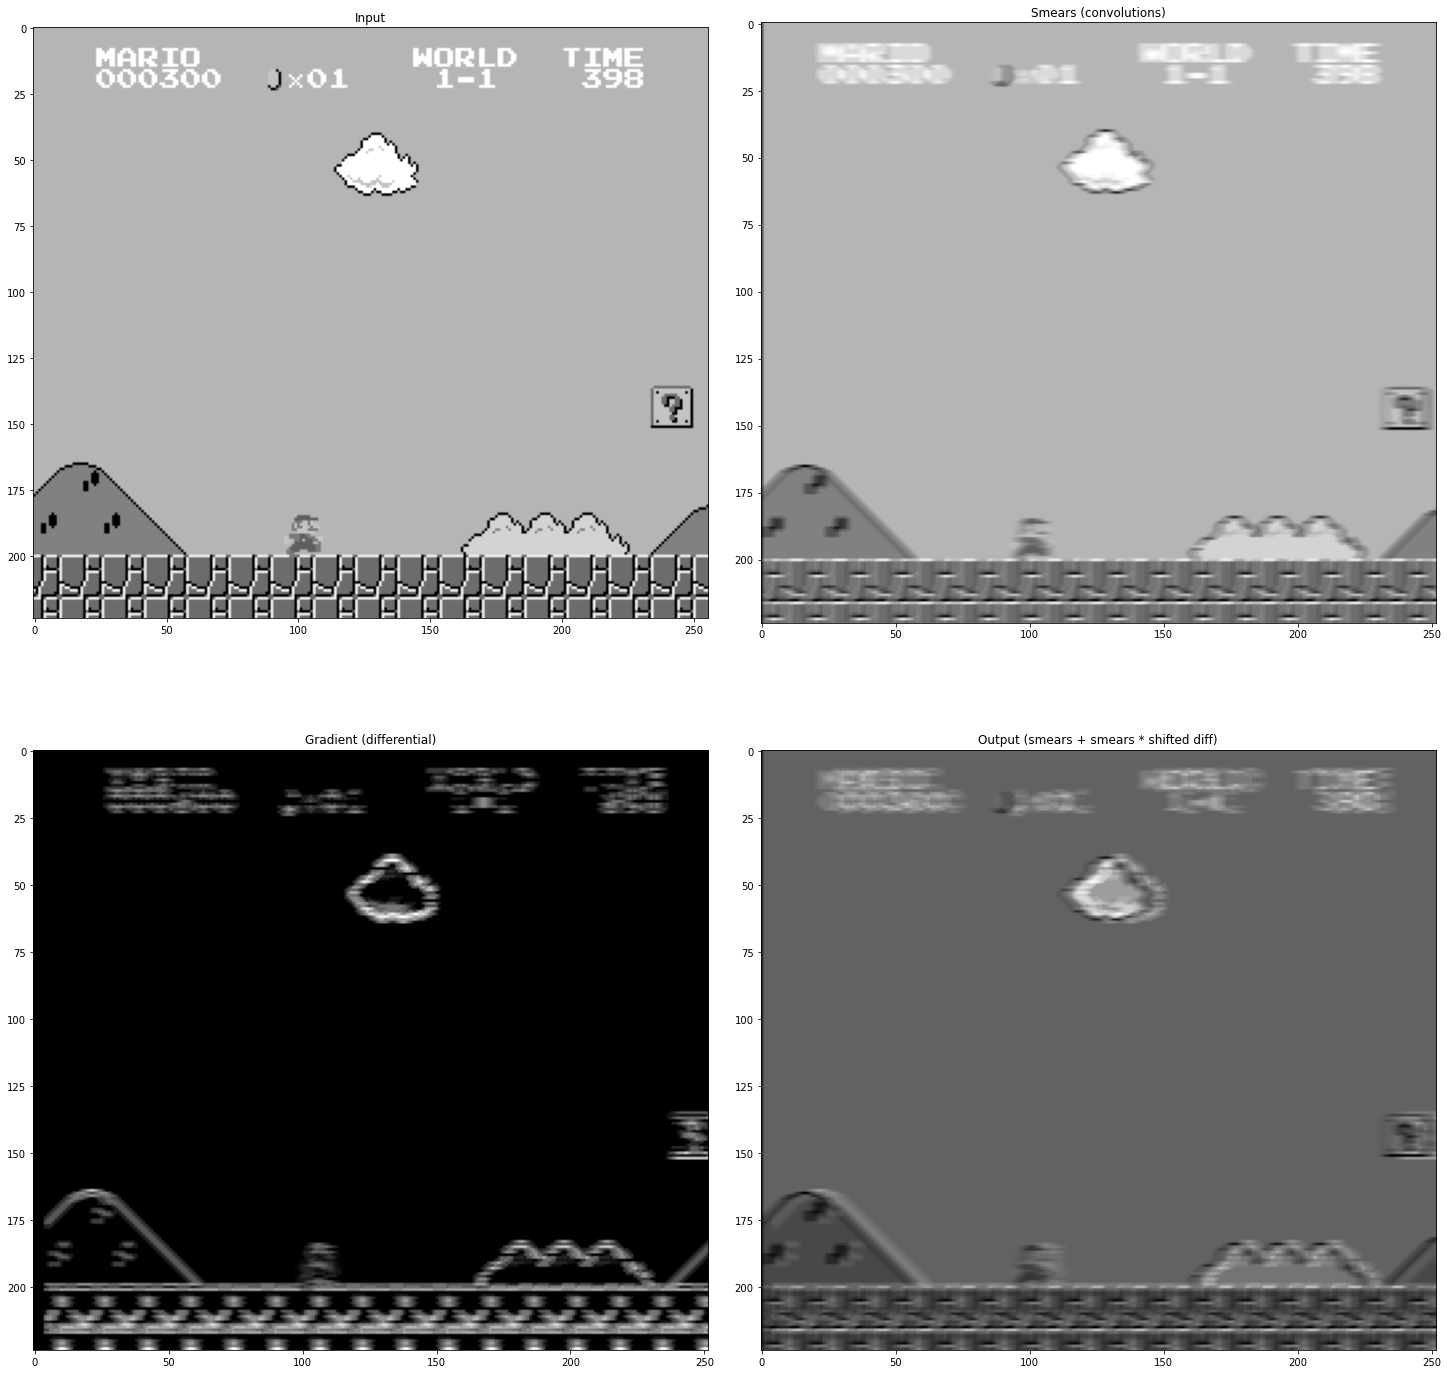

In [42]:

print("Luma shape is " + str(luma.shape))

print("Convoluting...", end='')

smear = np.apply_along_axis( lambda x: row_convolve(x, 5), axis=1, arr=luma )

print("done, smear shape is " + str(smear.shape))
print("Smearing...", end='')
for i in range(1, shiftpx):
    smear = smear + shift(smear, 0, i) * 1/i

print("done. Smear shape is " + str(smear.shape))

print("Diffing...", end='')

diff = shift(np.absolute(np.gradient(luma)[0]), 0, shiftpx)
print("smearing diff...", end='')


#Convolve and normalize
diff = np.apply_along_axis( lambda x: row_convolve(x, 5), axis=1, arr=diff )
diff *= 1/diff.max()
diff = shift(diff, 0, shiftpx*2)
print("done. Diff shape is " + str(diff.shape))
print("Expanding...", end='')


smear = expand(smear, diff)
smear *= 1/smear.max()

print("done. Smear shape is " + str(smear.shape))

output = smear + smear*diff

fig, plots = plt.subplots(2, 2, squeeze=True,
                          gridspec_kw={"hspace": 0.5, "wspace":0.7},
                          constrained_layout=True,
                          figsize= (20, 20),)



plotin = plots[0][0].imshow(luma, cmap="Greys_r")
plots[0][0].set_title("Input")
#fig.colorbar(plotred, ax=plots[0])

plotsmear = plots[0][1].imshow(smear, cmap="Greys_r")
plots[0][1].set_title("Smears (convolutions)")

plotdiff = plots[1][0].imshow(diff, cmap="Greys_r")
plots[1][0].set_title("Gradient (differential)")

plotout = plots[1][1].imshow(output, cmap="Greys_r")
plots[1][1].set_title("Output (smears + smears * shifted diff)")

plt.show()